In [1]:
#!/usr/bin/env python
import numpy as np
import math as m
import pylab as pl
from matplotlib import colors
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from colormaps import spectral
from matplotlib.colors import ColorConverter
from scipy import special
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# Font properties
# Note: TNR required for bolding due to font manager bug
# Math font for compact, times-like scientific notation
# Exit out of notebook before changing
times_font=True
if times_font:
    font_bold = fm.FontProperties(family='Times New Roman', style='normal', size=14, weight='bold', stretch='normal')
    font      = fm.FontProperties(family='Times', style='normal', size=14, weight='normal', stretch='normal')
    font_name ='Times'
    plt.rcParams["mathtext.fontset"] = "stix"#"stixsans"
else:
    font_name ='Dejavu Sans'
    font_bold = fm.FontProperties(family='Dejavu Sans', style='normal', size=14, weight='bold', stretch='normal')
    font      = fm.FontProperties(family='Dejavu Sans', style='normal', size=14, weight='normal', stretch='normal')

# Spectral custom colors
ColorConverter.colors['e']=(94/256, 79/256, 162/256)
ColorConverter.colors['g']=(50/256, 136/256, 189/256)
ColorConverter.colors['h']=(102/256, 194/256, 165/256)
ColorConverter.colors['i']=(253/256, 174/256, 97/256)
ColorConverter.colors['j']=(219/256, 55/256, 82/256)

In [2]:
## Brad Greig's fiducial theory and confidence limits for redshift 7
# GalaxyParam_LF+NF+Tau

def theory_fiducial(hubble_param=0.71):
    
    
    #Fourier mode (k [Mpc^-1]), 68th, 95th and 99th percentiles on the power spectrum in units of mK^2
    brad_k = np.array([0.02094395,0.03183814,0.0477084,0.06481693,0.0846983,0.1122589,0.1512655,0.2037167,0.2749778,0.3717481,0.5018322,0.6776517,0.9149306,1.235268,1.6676,2.207298,2.79783])
    brad_68 = np.array([2.06836030818,9.33650238046,13.5354885655,27.9094808815,31.8379169811,35.6549002097,
               37.7766299375,34.7228577191,22.5256589937,19.1373452916,19.0715957566,18.8232315706,18.1639861695,
               18.6493671092,21.4087292929,28.7580668946,40.4441293602])
    brad_95 = np.array([3.00633765723,12.8642551767,18.6682120582,38.322192403,43.5651253669,49.1075159329,
               51.9213041607,48.790639303,31.3894142399,26.2910138229,26.8292876974,26.5396841581,26.0301170622,
               27.1653881665,31.5002616162,42.7424864461,60.1632270707])
    brad_99 = np.array([3.277767,13.62931,19.91,40.66932,46.2304,52.1699,55.14123,52.86583,34.2097,28.67557,29.69817,29.57222,
               29.46968,30.93632,35.9361,48.86067,68.80418])

    #k (Mpc^-1) and fiducial
    brad_k_fid = np.array([2.094395e-02,3.183814e-02,4.770840e-02,6.481693e-02,8.469830e-02,1.122589e-01, 1.512655e-01,2.037167e-01,2.749778e-01,3.717481e-01,
                5.018322e-01,6.776517e-01,9.149306e-01,1.235268e+00,1.667600e+00,2.207298e+00,2.797836e+00])
    brad_fiducial = np.array([3.148450e-01,1.371862e+00,2.112182e+00,4.716543e+00,6.822401e+00,1.036046e+01,1.477729e+01,9.501991e+00,8.793401e+00,7.287165e+00,
                    6.430653e+00,5.709567e+00,5.390083e+00,5.408442e+00,6.280324e+00,8.959497e+00,1.353618e+01])

    brad_k_fid = brad_k_fid/hubble_param
    brad_k = brad_k/hubble_param
    
    return brad_k_fid, brad_fiducial, brad_95

## Load IDL text files 
# Expected header: k bin max (h Mpc^-1), power (mK^2 h^-3 Mpc^3), sigma (mK^2 h^-3 Mpc^3), 
# expected noise (mK^2 h^-3 Mpc^3), observed noise (mK^2 h^-3 Mpc^3), sim noise power (mK^2 h^-3 Mpc^3),
# sim noise diff (mK^2 h^-3 Mpc^3)

def load_IDL_data(file_name,hubble_param=0.71):
    
    
    # Load data and select
    data = np.loadtxt(file_name,skiprows=1)
    k_edges = data[:,0] # Lower and upper edge of bin, (h Mpc^-1)
    power = data[1:,1] # Observed power in each bin, (mK^2 h^-3 Mpc^3), first entry is a placeholder
    sigma = data[1:,2]
     
    # Construct k center from the edges
    n_k_edges = len(k_edges)
    k_center = (k_edges[1:n_k_edges]+k_edges[0:n_k_edges-1])/2.
        
    # Construct power in mK^2 units
    delta = (power)*(k_center**3.)/(2*np.pi**2)
    dsigma=sigma*(k_center**3.)/(2.*np.pi**2)

    # Construct k in h Mpc^-1. The cake is a lie.
    #k_edges=k_edges/hubble_param
        
    # Create histogram style data set by repeating the data 
    # Duplicate the bin edges so each bin has left and right data point
    # Duplicate the power so each bin edge has a measurement
    k_edges_hist  = np.repeat(k_edges,2)[1:-1]
    delta_hist  = np.repeat(delta,2)
    dsigma_hist  = np.repeat(dsigma,2)

    return k_edges_hist, delta_hist, dsigma_hist


## Construct upper limits using two sigma prior

def limits_2sigma(delta_hist, dsigma_hist):
    
    limit_percent = 0.97725 #2 sigma
    limits_hist=dsigma_hist*(special.erfinv(limit_percent-(1.-limit_percent)*special.erf((delta_hist)/dsigma_hist/np.sqrt(2)))*np.sqrt(2))+(delta_hist)

    return limits_hist

## Add error bars to a plot
# Force them to end at plot boundaries for aesthetics

def add_errors(k_edges, dsigma_hist, delta_hist, min_k, max_k, min_d, max_d, limits_hist):
    
    #Find the left and right boundaries of plot
    inds1 = np.argwhere(k_edges > min_k).T[0]
    inds2 = np.argwhere(k_edges[inds1] < max_k).T[0]
    k_in_plot = k_edges[inds1[inds2]]
    d_in_plot = delta_hist[inds1[inds2]]
    l_in_plot = limits_hist[inds1[inds2]]
    
    #Construct error bars
    error_low = (dsigma_hist[inds1[inds2]]*2.) #The bottom edge of the 2sigma error bar

    #Remove trailing edge of histogram for plotting purposes
    d_in_plot = d_in_plot[range(0,len(k_in_plot),2)]
    l_in_plot = l_in_plot[range(0,len(k_in_plot),2)]
    error_low = error_low[range(0,len(k_in_plot),2)]
    k_in_plot = k_in_plot[range(0,len(k_in_plot),2)]


    # Force the error bars to end at the bottom of the plot if noise-dominated
    low_inds = np.argwhere(d_in_plot < 0)
    if low_inds.size > 0:
        error_low[low_inds] = np.abs(d_in_plot[low_inds])
    
    low_inds = np.argwhere((np.abs(d_in_plot) - error_low) < min_d)
    if low_inds.size > 0:
        error_low[low_inds] = np.abs(d_in_plot[low_inds]) - min_d    

    error_low = np.abs(d_in_plot)-error_low
    height_rect = l_in_plot - error_low

    return k_in_plot, error_low, height_rect
    

In [7]:
def plot_hist(idl_files,max_k=1.9,min_k=.14,min_d=1,max_d=10**8,mode='wide',flagcoarse=False,
             savefig=False, figname='', full_legend=False):
    
    fig = plt.figure(figsize=(21,21))
    #fig, ax = plt.subplots()
    fontsize=22
    linewidth=4
    
    # Read-in and calculate limits
    brad_k_fid, brad_fiducial, brad_95 = theory_fiducial()
    k_edges_hist_xx, delta_hist_xx, dsigma_hist_xx = load_IDL_data(idl_files[0])
    limits_hist_xx = limits_2sigma(delta_hist_xx, dsigma_hist_xx)
    k_edges_hist_yy, delta_hist_yy, dsigma_hist_yy = load_IDL_data(idl_files[1])
    limits_hist_yy = limits_2sigma(delta_hist_yy, dsigma_hist_yy)
    
    # Set 0's to nans for plotting purposes
    limits_hist_xx[delta_hist_xx==0] = np.nan
    limits_hist_yy[delta_hist_yy==0] = np.nan
    dsigma_hist_xx[delta_hist_xx==0] = np.nan
    dsigma_hist_yy[delta_hist_yy==0] = np.nan
    delta_hist_xx[delta_hist_xx==0] = np.nan
    delta_hist_yy[delta_hist_yy==0] = np.nan
    
    if flagcoarse:
        flag_inds1 = np.argwhere((k_edges_hist_xx > .375) & (k_edges_hist_xx < .50)).T[0]
        flag_inds1 = np.append(flag_inds1[0]-1,flag_inds1)
        flag_inds1 = np.append(flag_inds1, flag_inds1[-1]+1)
        
        flag_inds2 = np.argwhere((k_edges_hist_xx > .78) & (k_edges_hist_xx < .91)).T[0]
        flag_inds2 = np.append(flag_inds2[0]-1,flag_inds2)
        flag_inds2 = np.append(flag_inds2, flag_inds2[-1]+1)
        
        flag_inds3 = np.argwhere((k_edges_hist_xx > 1.23) & (k_edges_hist_xx < 1.35))
        flag_inds3 = np.append(flag_inds3[0]-1,flag_inds3)
        flag_inds3 = np.append(flag_inds3, flag_inds3[-1]+1)
        
        flag_inds4 = np.argwhere((k_edges_hist_xx > 1.65))
        flag_inds4 = np.append(flag_inds4[0]-1,flag_inds4)
        
        flag_inds = np.append(flag_inds1,flag_inds2)
        flag_inds = np.append(flag_inds, flag_inds3)
        flag_inds = np.append(flag_inds, flag_inds4)
        
        limits_hist_xx[flag_inds] = np.nan
        limits_hist_yy[flag_inds] = np.nan
        dsigma_hist_xx[flag_inds] = np.nan
        dsigma_hist_yy[flag_inds] = np.nan
        delta_hist_xx[flag_inds] = np.nan
        delta_hist_yy[flag_inds] = np.nan
    
    # Print lowest limit to screen
    min_lim_xx_ind=np.nanargmin(limits_hist_xx)
    print('#Limit: '+str(limits_hist_xx[min_lim_xx_ind])+' mK^2, at k = '+ \
        str((k_edges_hist_xx[min_lim_xx_ind]+k_edges_hist_xx[min_lim_xx_ind])/2)+' h Mpc^-1 for xx')
    min_lim_yy_ind=np.nanargmin(limits_hist_yy)
    print('#Limit: '+str(limits_hist_yy[min_lim_yy_ind])+' mK^2, at k = '+ \
        str((k_edges_hist_yy[min_lim_yy_ind]+k_edges_hist_yy[min_lim_yy_ind])/2)+' h Mpc^-1 for yy')
    
    # Plotting defaults
    #[left, bottom, width, height]
    subplot_loc_left = [.1,.6,.4,.25]
    subplot_loc_right = [.5,.6,.4,.25]
    subplot_loc_top = [.1,.5,.4,.25]
    subplot_loc_bottom = [.1,.25,.4,.25]
    #hist_color = ['black','orangered','orangered','peru','peru']
    hist_color = ['black','darkcyan','darkcyan','peru','peru']
    legend1_loc = (0.22, 0.84)
    legend2_loc = (0.62, 0.88)
    
    if mode == 'xx':
        subplot_loc = [subplot_loc_left] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4,10**6,10**8]]
        xticklabel = [[10**0]]
        
    if mode == 'yy':
        k_edges_hist_xx = k_edges_hist_yy
        delta_hist_xx = delta_hist_yy
        dsigma_hist_xx = dsigma_hist_yy
        limits_hist_xx = limits_hist_yy
        
        subplot_loc = [subplot_loc_left] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4,10**6,10**8]]
        xticklabel = [[10**0]]
        
    if mode == 'wide':
        subplot_loc = [subplot_loc_left,subplot_loc_right] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)','','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4,10**6,10**8],[]]
        xticklabel = [[10**0],[10**0]]

    if mode == 'tall':
        subplot_loc = [subplot_loc_top,subplot_loc_bottom] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)','$\Delta^2$ (mK$^2$)','']
        yticklabel = [[10**2,10**4,10**6,10**8],[10**2,10**4,10**6,10**8]]
        xticklabel = [[],[10**0]]
    
    
    #Plot measured power, limits, theory
    plt.axes(subplot_loc[0])
    plt.plot(k_edges_hist_xx, dsigma_hist_xx, ls='dashed', color=hist_color[2],linewidth=linewidth)
    plt.plot(k_edges_hist_xx, delta_hist_xx, ls='solid', color=hist_color[0],linewidth=linewidth)
    plt.plot(k_edges_hist_xx, limits_hist_xx, ls='solid', color=hist_color[1],linewidth=linewidth)
    plt.plot(brad_k_fid, brad_fiducial, ls='solid', color=hist_color[3],linewidth=linewidth)
    plt.plot(brad_k_fid, brad_95, ls='dashed', color=hist_color[3],linewidth=linewidth)
    currentAxis = plt.gca()
    
    #Plot error bar
    k_in_plot,error_low,height_rect = add_errors(k_edges_hist_xx, dsigma_hist_xx, delta_hist_xx, min_k, max_k, min_d, max_d, limits_hist_xx)
    for k_i in range(0,len(k_in_plot)-1):
        currentAxis.add_patch(Rectangle((k_in_plot[k_i], error_low[k_i]),
                                        (k_in_plot[0]-k_in_plot[1]),
                                        height_rect[k_i],
                                        fill=True,facecolor='grey',alpha=.5))
    
    #Plot defaults
    plt.loglog()
    plt.tick_params(direction='in', color='k', which='both', top=True, bottom=True, 
                    left=True, right=True, labelsize=fontsize, width=2, length=6)
    plt.xlim(min_k,max_k)
    plt.ylim(min_d,max_d)
    plt.yticks(yticklabel[0])
    plt.xticks(xticklabel[0])
    plt.ylabel(axeslabel[0], fontsize=fontsize)
    plt.xlabel(axeslabel[1], fontsize=fontsize)
             
    #Tick Formatting
    a=plt.gca()
    a.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=20))
    a.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    # Legend
    f1_label = ['measured power', '2$\sigma$ upper limit', 'noise level']
    linestyle = ['solid','solid','dashed']
    patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth, linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
    legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
                    fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
    legend1._legend_box.align='left'
    legend1.get_title().set_multialignment('center')
    a.add_artist(legend1)
    
    if full_legend | (mode != 'wide') | (mode != 'tall'):
        # Theory part of the legend
        f1_label = ['fiducial theory', '95% confidence']
        linestyle = ['solid','dashed']
        patches = [ plt.plot([],[], mec=None, color=hist_color[type_i+3], linewidth=linewidth, linestyle=linestyle[type_i],
                label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend1 = plt.legend(handles=patches, bbox_to_anchor=legend2_loc,loc='center', ncol=1, frameon=False,
                            fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
        legend1._legend_box.align='left'
        legend1.get_title().set_multialignment('center')
        a.add_artist(legend1)
    
    if (mode == 'wide') | (mode == 'tall'):
        hist_color = ['black','darkmagenta','darkmagenta','peru','peru']
        
        #Plot measured power, limits, theory
        plt.axes(subplot_loc[1])
        plt.plot(k_edges_hist_yy, dsigma_hist_yy, ls='dashed', color=hist_color[2],linewidth=linewidth)
        plt.plot(k_edges_hist_yy, delta_hist_yy, ls='solid', color=hist_color[0],linewidth=linewidth)
        plt.plot(k_edges_hist_yy, limits_hist_yy, ls='solid', color=hist_color[1],linewidth=linewidth)
        plt.plot(brad_k_fid, brad_fiducial, ls='solid', color=hist_color[3],linewidth=linewidth)
        plt.plot(brad_k_fid, brad_95, ls='dashed', color=hist_color[4],linewidth=linewidth)
        currentAxis = plt.gca()
    
        #Plot error bar
        k_in_plot,error_low,height_rect = add_errors(k_edges_hist_yy, dsigma_hist_yy, delta_hist_yy, min_k, max_k, min_d, max_d, limits_hist_yy)
        for k_i in range(0,len(k_in_plot)-1):
            currentAxis.add_patch(Rectangle((k_in_plot[k_i], error_low[k_i]),
                                            (k_in_plot[0]-k_in_plot[1]),
                                            height_rect[k_i],
                                            fill=True,facecolor='grey',alpha=.5))
    
        #Plot defaults
        plt.loglog()
        plt.tick_params(direction='in', color='k', which='both', top=True, bottom=True, 
                        left=True, right=True, labelsize=fontsize, width=2, length=6)
        plt.xlim(min_k,max_k)
        plt.ylim(min_d,max_d)
        plt.yticks(yticklabel[1])
        plt.xticks(xticklabel[1])
        plt.ylabel(axeslabel[2], fontsize=fontsize)
        plt.xlabel(axeslabel[3], fontsize=fontsize)
             
        #Tick Formatting
        a=plt.gca()
        a.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=20))
        a.yaxis.set_minor_formatter(ticker.NullFormatter())
        
        if full_legend:
            # Legend
            f1_label = ['measured power', '2$\sigma$ upper limit', 'noise level']
            linestyle = ['solid','solid','dashed']
            patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth, linestyle=linestyle[type_i],
                        label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
            legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
                        fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
            legend1._legend_box.align='left'
            legend1.get_title().set_multialignment('center')
            a.add_artist(legend1)
            
            legend1_loc = legend2_loc
            
        # Theory part of the legend
        f1_label = ['fiducial theory', '95% confidence']
        linestyle = ['solid','dashed']
        patches = [ plt.plot([],[], mec=None, color=hist_color[type_i+3], linewidth=linewidth, linestyle=linestyle[type_i],
                label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
                            fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
        legend1._legend_box.align='left'
        legend1.get_title().set_multialignment('center')
        a.add_artist(legend1)
        
    
    # Saving or showing the figure
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=300)
        plt.close()
        
    else:
        plt.show()
    

# Expect xx, then yy

#Barry et al 2019b
#idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_btl_noalltv_noocc4_cubeXX__even_odd_joint_fullimg_ch9-126_res_xx_averemove_swbh_dencorr_no_120deg_wedge_kperplambda18-80_kpar0.15-200_1dkpower.txt',
#            '/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_btl_noalltv_noocc4_cubeXX__even_odd_joint_fullimg_ch9-126_res_yy_averemove_swbh_dencorr_no_120deg_wedge_kperplambda18-80_kpar0.15-200_1dkpower.txt']

#Beardsley et al 2016
#idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_wedge_cut_plus_res_cut_cubeXX__even_odd_joint_ch9-126_res_xx_averemove_swbh_dencorr_no_120deg_wedge_kperplambda10-70_kpar0.15-200_1dkpower.txt',
#             '/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_wedge_cut_plus_res_cut_cubeXX__even_odd_joint_ch9-126_res_yy_averemove_swbh_dencorr_no_120deg_wedge_kperplambda10-70_kpar0.15-200_1dkpower.txt']

#Beardsley and Barry analysis compare
#idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_wedge_cut_plus_res_cut_cubeXX__even_odd_joint_ch9-126_res_yy_averemove_swbh_dencorr_no_120deg_wedge_kperplambda10-70_kpar0.15-200_1dkpower.txt',
#             '/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_sub_cubes_cubeXX__even_odd_joint_fullimg_ch9-126_res_yy_dft_averemove_swbh_dencorr_no_120deg_wedge_kperplambda10-70_kpar0.15-200_1dkpower.txt']

#Barry analysis and RFI flagging compare
#idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_sub_cubes_cubeXX__even_odd_joint_fullimg_ch9-126_res_yy_dft_averemove_swbh_dencorr_no_120deg_wedge_kperplambda10-70_kpar0.15-200_1dkpower.txt',
#             '/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_btl_noalltv_noocc4_cubeXX__even_odd_joint_fullimg_ch9-126_res_yy_averemove_swbh_dencorr_no_120deg_wedge_kperplambda18-80_kpar0.15-200_1dkpower.txt']
#idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_beardsley_thesis_list_zenith_cubeXX__even_odd_joint_fullimg_ch9-126_res_yy_averemove_swbh_dencorr_no_120deg_wedge_kperplambda18-80_kpar0.15-200_1dkpower.txt',
#             '/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_btl_noalltv_noocc4_zenith_cubeXX__even_odd_joint_fullimg_ch9-126_res_yy_averemove_swbh_dencorr_no_120deg_wedge_kperplambda18-80_kpar0.15-200_1dkpower.txt']


idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_try_again_sub_cubes_cubeXX__even_odd_joint_noimgclip_ch9-126_res_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower_pyfhd.txt',
            '/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_56_5metric_cubeXX__even_odd_joint_fullimg_ch9-126_res_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower.txt']

#idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_10_ssins_extragalactic_cubeXX__even_odd_joint_noimgclip_ch9-126_res_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower.txt',
#            '/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_10_ssins_eg_cubeXX__even_odd_joint_noimgclip_ch9-126_res_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower.txt']

plt_dir = '/Users/nicholebarry/MWA/data/limit_2019/'

# mode can be wide, tall, xx, or yy
plot_hist(idl_files,max_k=1.9,min_k=.14,min_d=2,max_d=10**8,mode='xx',flagcoarse=True, savefig=True, figname=plt_dir+'yy_pyfhdcomp_fhd.png',full_legend=True)


/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_82116/2699302150.py:49: RuntimeWarning: invalid value encountered in multiply
  dsigma=sigma*(k_center**3.)/(2.*np.pi**2)


#Limit: 97162.15931459167 mK^2, at k = 0.304959 h Mpc^-1 for xx
#Limit: 8538.090581300588 mK^2, at k = 0.246872 h Mpc^-1 for yy


In [15]:
print((62035.71293055661 - 61799.506092103155)/62035.71293055661)
print(62035.71293055661 - 61799.506092103155)
print((62035.71293055661 - 61799.506092103155) /10)
print((73480.6638981966 - 73295.79648747423)/73480.6638981966)

0.003807594485419552
236.20683845345775
23.620683845345773
0.0025158647311418806


In [16]:
61*2

122

In [19]:
#Plot just model or measured power data -- not for limits

def plot_hist(idl_files,max_k=1.9,min_k=.14,min_d=1,max_d=10**8,mode='wide',flagcoarse=False,
             savefig=False, figname='', full_legend=False):
    
    fig = plt.figure(figsize=(21,21))
    #fig, ax = plt.subplots()
    fontsize=22
    linewidth=4
    
    # Read-in and calculate limits
    brad_k_fid, brad_fiducial, brad_95 = theory_fiducial()
    k_edges_hist_xx, delta_hist_xx, dsigma_hist_xx = load_IDL_data(idl_files[0])
    k_edges_hist_yy, delta_hist_yy, dsigma_hist_yy = load_IDL_data(idl_files[1])
    
    # Set 0's to nans for plotting purposes
    dsigma_hist_xx[delta_hist_xx==0] = np.nan
    dsigma_hist_yy[delta_hist_yy==0] = np.nan
    delta_hist_xx[delta_hist_xx==0] = np.nan
    delta_hist_yy[delta_hist_yy==0] = np.nan

    # Plotting defaults
    #[left, bottom, width, height]
    subplot_loc_left = [.1,.6,.4,.25]
    subplot_loc_right = [.5,.6,.4,.25]
    subplot_loc_top = [.1,.5,.4,.25]
    subplot_loc_bottom = [.1,.25,.4,.25]
    #hist_color = ['black','orangered','orangered','peru','peru']
    hist_color = ['black','darkcyan','darkcyan','peru','peru']
    legend1_loc = (0.22, 0.84)
    legend2_loc = (0.62, 0.88)
    
    if mode == 'xx':
        subplot_loc = [subplot_loc_left] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4,10**6,10**8]]
        xticklabel = [[10**0]]
        
    if mode == 'yy':
        k_edges_hist_xx = k_edges_hist_yy
        delta_hist_xx = delta_hist_yy
        dsigma_hist_xx = dsigma_hist_yy
        
        subplot_loc = [subplot_loc_left] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4,10**6,10**8]]
        xticklabel = [[10**0]]
        
    if mode == 'wide':
        subplot_loc = [subplot_loc_left,subplot_loc_right] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)','','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4,10**6,10**8],[]]
        xticklabel = [[10**0],[10**0]]

    if mode == 'tall':
        subplot_loc = [subplot_loc_top,subplot_loc_bottom] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)','$\Delta^2$ (mK$^2$)','']
        yticklabel = [[10**2,10**4,10**6,10**8],[10**2,10**4,10**6,10**8]]
        xticklabel = [[],[10**0]]
    
    
    #Plot measured power, limits, theory
    plt.axes(subplot_loc[0])
    plt.plot(k_edges_hist_xx, dsigma_hist_xx, ls='dashed', color=hist_color[2],linewidth=linewidth)
    plt.plot(k_edges_hist_xx, delta_hist_xx, ls='solid', color=hist_color[1],linewidth=linewidth)
    plt.plot(brad_k_fid, brad_fiducial, ls='solid', color=hist_color[3],linewidth=linewidth)
    plt.plot(brad_k_fid, brad_95, ls='dashed', color=hist_color[3],linewidth=linewidth)
    currentAxis = plt.gca()
    
    #Plot defaults
    plt.loglog()
    plt.tick_params(direction='in', color='k', which='both', top=True, bottom=True, 
                    left=True, right=True, labelsize=fontsize, width=2, length=6)
    plt.xlim(min_k,max_k)
    plt.ylim(min_d,max_d)
    plt.yticks(yticklabel[0])
    plt.xticks(xticklabel[0])
    plt.ylabel(axeslabel[0], fontsize=fontsize)
    plt.xlabel(axeslabel[1], fontsize=fontsize)
             
    #Tick Formatting
    a=plt.gca()
    a.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=20))
    a.yaxis.set_minor_formatter(ticker.NullFormatter())
    
    # Legend
    f1_label = ['measured power', 'noise level']
    linestyle = ['solid','dashed']
    patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth, linestyle=linestyle[type_i],
            label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
    legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
                    fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
    legend1._legend_box.align='left'
    legend1.get_title().set_multialignment('center')
    a.add_artist(legend1)
    
    if full_legend | (mode != 'wide') | (mode != 'tall'):
        # Theory part of the legend
        f1_label = ['fiducial theory', '95% confidence']
        linestyle = ['solid','dashed']
        patches = [ plt.plot([],[], mec=None, color=hist_color[type_i+3], linewidth=linewidth, linestyle=linestyle[type_i],
                label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend1 = plt.legend(handles=patches, bbox_to_anchor=legend2_loc,loc='center', ncol=1, frameon=False,
                            fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
        legend1._legend_box.align='left'
        legend1.get_title().set_multialignment('center')
        a.add_artist(legend1)
    
    if (mode == 'wide') | (mode == 'tall'):
        hist_color = ['black','darkmagenta','darkmagenta','peru','peru']
        
        #Plot measured power, limits, theory
        plt.axes(subplot_loc[1])
        plt.plot(k_edges_hist_yy, dsigma_hist_yy, ls='dashed', color=hist_color[2],linewidth=linewidth)
        plt.plot(k_edges_hist_yy, delta_hist_yy, ls='solid', color=hist_color[0],linewidth=linewidth)
        plt.plot(k_edges_hist_yy, limits_hist_yy, ls='solid', color=hist_color[1],linewidth=linewidth)
        plt.plot(brad_k_fid, brad_fiducial, ls='solid', color=hist_color[3],linewidth=linewidth)
        plt.plot(brad_k_fid, brad_95, ls='dashed', color=hist_color[4],linewidth=linewidth)
        currentAxis = plt.gca()
    
        #Plot error bar
        k_in_plot,error_low,height_rect = add_errors(k_edges_hist_yy, dsigma_hist_yy, delta_hist_yy, min_k, max_k, min_d, max_d, limits_hist_yy)
        for k_i in range(0,len(k_in_plot)-1):
            currentAxis.add_patch(Rectangle((k_in_plot[k_i], error_low[k_i]),
                                            (k_in_plot[0]-k_in_plot[1]),
                                            height_rect[k_i],
                                            fill=True,facecolor='grey',alpha=.5))
    
        #Plot defaults
        plt.loglog()
        plt.tick_params(direction='in', color='k', which='both', top=True, bottom=True, 
                        left=True, right=True, labelsize=fontsize, width=2, length=6)
        plt.xlim(min_k,max_k)
        plt.ylim(min_d,max_d)
        plt.yticks(yticklabel[1])
        plt.xticks(xticklabel[1])
        plt.ylabel(axeslabel[2], fontsize=fontsize)
        plt.xlabel(axeslabel[3], fontsize=fontsize)
             
        #Tick Formatting
        a=plt.gca()
        a.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=20))
        a.yaxis.set_minor_formatter(ticker.NullFormatter())
        
        if full_legend:
            # Legend
            f1_label = ['measured power', 'noise level']
            linestyle = ['solid','dashed']
            patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth, linestyle=linestyle[type_i],
                        label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
            legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
                        fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
            legend1._legend_box.align='left'
            legend1.get_title().set_multialignment('center')
            a.add_artist(legend1)
            
            legend1_loc = legend2_loc
            
        # Theory part of the legend
        f1_label = ['fiducial theory', '95% confidence']
        linestyle = ['solid','dashed']
        patches = [ plt.plot([],[], mec=None, color=hist_color[type_i+3], linewidth=linewidth, linestyle=linestyle[type_i],
                label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
        legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
                            fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
        legend1._legend_box.align='left'
        legend1.get_title().set_multialignment('center')
        a.add_artist(legend1)
        
    
    # Saving or showing the figure
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=300)
        plt.close()
        
    else:
        plt.show()
    

# Expect xx, then yy
idl_files = ['/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_10_ssins_extragalactic_cubeXX__even_odd_joint_noimgclip_ch9-126_model_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower.txt',
            '/Users/nicholebarry/MWA/data/limit_2019/Combined_obs_10_ssins_galactic_cubeXX__even_odd_joint_noimgclip_ch9-126_model_yy_dft_averemove_swbh7_dencorr_no_120deg_wedge_kperplambda10-80_kpar0.15-200_1dkpower.txt']

plt_dir = '/Users/nicholebarry/MWA/data/limit_2019/'

# mode can be wide, tall, xx, or yy
plot_hist(idl_files,max_k=1.9,min_k=.14,min_d=2,max_d=10**8,mode='yy',flagcoarse=True, savefig=True, figname=plt_dir+'yy_nb_analysis_eg_test.png',full_legend=True)


/var/folders/bq/wmsr1m_d2c94qwkmz9xyr3g80000gn/T/ipykernel_94972/2699302150.py:49: RuntimeWarning: invalid value encountered in multiply
  dsigma=sigma*(k_center**3.)/(2.*np.pi**2)


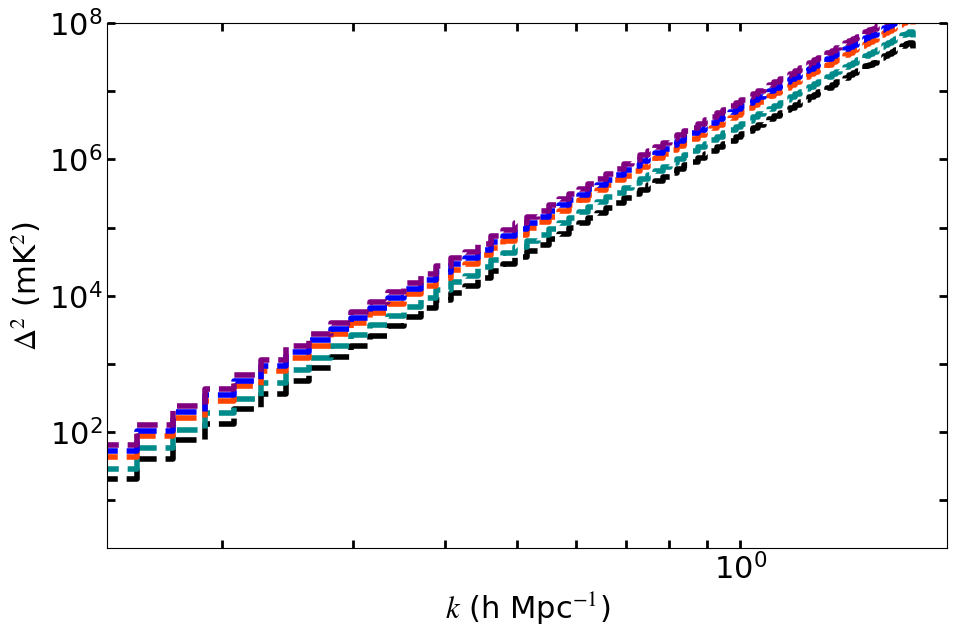

In [19]:
#Plot noise lines from multiples sources

def plot_hist(idl_files,max_k=1.9,min_k=.14,min_d=1,max_d=10**8,mode='wide',flagcoarse=False,
             savefig=False, figname='', full_legend=False):
    
    fig = plt.figure(figsize=(21,21))
    #fig, ax = plt.subplots()
    fontsize=22
    linewidth=4
    
    # Read-in and calculate limits
    brad_k_fid, brad_fiducial, brad_95 = theory_fiducial()
    
    k_edges_hist = np.empty((0, 3))
    delta_hist = np.empty((0, 3))
    dsigma_hist = np.empty((0, 3))
    for idl_file in idl_files:
        k_edges_hist_temp, delta_hist_temp, dsigma_hist_temp = load_IDL_data(idl_file)
        if k_edges_hist.size == 0:
            k_edges_hist = k_edges_hist_temp[np.newaxis, :]
        else:
            k_edges_hist = np.concatenate((k_edges_hist, k_edges_hist_temp[np.newaxis, :]), axis=0)

        if delta_hist.size == 0:
            delta_hist = delta_hist_temp[np.newaxis, :]
        else:
            delta_hist = np.concatenate((delta_hist, delta_hist_temp[np.newaxis, :]), axis=0)

        if dsigma_hist.size == 0:
            dsigma_hist = dsigma_hist_temp[np.newaxis, :]
        else:
            dsigma_hist = np.concatenate((dsigma_hist, dsigma_hist_temp[np.newaxis, :]), axis=0)
    
    # Set 0's to nans for plotting purposes
    for index, i in enumerate(range(1, len(idl_files))):
        dsigma_hist[index,delta_hist[index,:]==0] = np.nan
        delta_hist[index,delta_hist[index,:]==0] = np.nan


    # Plotting defaults
    #[left, bottom, width, height]
    subplot_loc_left = [.1,.6,.4,.25]
    subplot_loc_right = [.5,.6,.4,.25]
    subplot_loc_top = [.1,.5,.4,.25]
    subplot_loc_bottom = [.1,.25,.4,.25]
    #hist_color = ['black','orangered','orangered','peru','peru']
    hist_color = ['black','darkcyan','orangered','blue','purple','green']
    legend1_loc = (0.22, 0.84)
    legend2_loc = (0.62, 0.88)
    
    if mode == 'xx':
        subplot_loc = [subplot_loc_left] 
        axeslabel = ['$\Delta^2$ (mK$^2$)','$k$ (h Mpc$^{-1}$)']
        yticklabel = [[10**2,10**4,10**6,10**8]]
        xticklabel = [[10**0]]
    
    #Plot measured power, limits, theory
    plt.axes(subplot_loc[0])
    for index, i in enumerate(range(1, len(idl_files))):
        plt.plot(k_edges_hist[index,:], dsigma_hist[index,:], ls='dashed', color=hist_color[index],linewidth=linewidth)

    currentAxis = plt.gca()
    
    #Plot defaults
    plt.loglog()
    plt.tick_params(direction='in', color='k', which='both', top=True, bottom=True, 
                    left=True, right=True, labelsize=fontsize, width=2, length=6)
    plt.xlim(min_k,max_k)
    plt.ylim(min_d,max_d)
    plt.yticks(yticklabel[0])
    plt.xticks(xticklabel[0])
    plt.ylabel(axeslabel[0], fontsize=fontsize)
    plt.xlabel(axeslabel[1], fontsize=fontsize)
             
    #Tick Formatting
    a=plt.gca()
    a.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=20))
    a.yaxis.set_minor_formatter(ticker.NullFormatter())
    
#     # Legend
#     f1_label = ['measured power', 'noise level']
#     linestyle = ['solid','dashed']
#     patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth, linestyle=linestyle[type_i],
#             label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
#     legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
#                     fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
#     legend1._legend_box.align='left'
#     legend1.get_title().set_multialignment('center')
#     a.add_artist(legend1)
    
#     if full_legend | (mode != 'wide') | (mode != 'tall'):
#         # Theory part of the legend
#         f1_label = ['fiducial theory', '95% confidence']
#         linestyle = ['solid','dashed']
#         patches = [ plt.plot([],[], mec=None, color=hist_color[type_i+3], linewidth=linewidth, linestyle=linestyle[type_i],
#                 label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
#         legend1 = plt.legend(handles=patches, bbox_to_anchor=legend2_loc,loc='center', ncol=1, frameon=False,
#                             fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
#         legend1._legend_box.align='left'
#         legend1.get_title().set_multialignment('center')
#         a.add_artist(legend1)
    
#     if (mode == 'wide') | (mode == 'tall'):
#         hist_color = ['black','darkmagenta','darkmagenta','peru','peru']
        
#         #Plot measured power, limits, theory
#         plt.axes(subplot_loc[1])
#         plt.plot(k_edges_hist_yy, dsigma_hist_yy, ls='dashed', color=hist_color[2],linewidth=linewidth)
#         plt.plot(k_edges_hist_yy, delta_hist_yy, ls='solid', color=hist_color[0],linewidth=linewidth)
#         plt.plot(k_edges_hist_yy, limits_hist_yy, ls='solid', color=hist_color[1],linewidth=linewidth)
#         plt.plot(brad_k_fid, brad_fiducial, ls='solid', color=hist_color[3],linewidth=linewidth)
#         plt.plot(brad_k_fid, brad_95, ls='dashed', color=hist_color[4],linewidth=linewidth)
#         currentAxis = plt.gca()
    
#         #Plot error bar
#         k_in_plot,error_low,height_rect = add_errors(k_edges_hist_yy, dsigma_hist_yy, delta_hist_yy, min_k, max_k, min_d, max_d, limits_hist_yy)
#         for k_i in range(0,len(k_in_plot)-1):
#             currentAxis.add_patch(Rectangle((k_in_plot[k_i], error_low[k_i]),
#                                             (k_in_plot[0]-k_in_plot[1]),
#                                             height_rect[k_i],
#                                             fill=True,facecolor='grey',alpha=.5))
    
#         #Plot defaults
#         plt.loglog()
#         plt.tick_params(direction='in', color='k', which='both', top=True, bottom=True, 
#                         left=True, right=True, labelsize=fontsize, width=2, length=6)
#         plt.xlim(min_k,max_k)
#         plt.ylim(min_d,max_d)
#         plt.yticks(yticklabel[1])
#         plt.xticks(xticklabel[1])
#         plt.ylabel(axeslabel[2], fontsize=fontsize)
#         plt.xlabel(axeslabel[3], fontsize=fontsize)
             
#         #Tick Formatting
#         a=plt.gca()
#         a.yaxis.set_minor_locator(ticker.LogLocator(base=10, numticks=20))
#         a.yaxis.set_minor_formatter(ticker.NullFormatter())
        
#         if full_legend:
#             # Legend
#             f1_label = ['measured power', 'noise level']
#             linestyle = ['solid','dashed']
#             patches = [ plt.plot([],[], mec=None, color=hist_color[type_i], linewidth=linewidth, linestyle=linestyle[type_i],
#                         label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
#             legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
#                         fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
#             legend1._legend_box.align='left'
#             legend1.get_title().set_multialignment('center')
#             a.add_artist(legend1)
            
#             legend1_loc = legend2_loc
            
#         # Theory part of the legend
#         f1_label = ['fiducial theory', '95% confidence']
#         linestyle = ['solid','dashed']
#         patches = [ plt.plot([],[], mec=None, color=hist_color[type_i+3], linewidth=linewidth, linestyle=linestyle[type_i],
#                 label="{:s}".format(f1_label[type_i]) )[0]  for type_i in range(len(f1_label)) ]
#         legend1 = plt.legend(handles=patches, bbox_to_anchor=legend1_loc,loc='center', ncol=1, frameon=False,
#                             fontsize=fontsize-4,title_fontsize=fontsize,handlelength=1.5)
#         legend1._legend_box.align='left'
#         legend1.get_title().set_multialignment('center')
#         a.add_artist(legend1)
        
    
    # Saving or showing the figure
    if savefig:
        plt.savefig(figname, bbox_inches='tight', dpi=300)
        plt.close()
        
    else:
        plt.show()
    

# Expect xx, then yy

idl_files = ['1088281088_gridded_uvf__even_odd_joint_noimgclip_uvavg2_dirty_yy_dft_averemove_swbh_dencorr_no_horizon_wedge_kperplambda10-50_1dkpower.txt',
            '1088281088_gridded_uvf__even_odd_joint_noimgclip_uvavg3_dirty_yy_dft_averemove_swbh_dencorr_no_horizon_wedge_kperplambda10-50_1dkpower.txt',
            '1088281088_gridded_uvf__even_odd_joint_noimgclip_uvavg4_dirty_yy_dft_averemove_swbh_dencorr_no_horizon_wedge_kperplambda10-50_1dkpower.txt',
            '1088281088_gridded_uvf__even_odd_joint_noimgclip_uvavg5_dirty_yy_dft_averemove_swbh_dencorr_no_horizon_wedge_kperplambda10-50_1dkpower.txt',
            '1088281088_gridded_uvf__even_odd_joint_noimgclip_uvavg6_dirty_yy_dft_averemove_swbh_dencorr_no_horizon_wedge_kperplambda10-50_1dkpower.txt',
            'Combined_obs_1088281088_cubeXX__even_odd_joint_noimgclip_dirty_yy_dft_averemove_swbh_dencorr_no_horizon_wedge_kperplambda10-50_1dkpower.txt']

idl_files = ['/Users/nicholebarry/MWA/data/noise_uvf/'+ idl_file for idl_file in idl_files]

plt_dir = '/Users/nicholebarry/MWA/data/noise_uvf/'

# mode can be wide, tall, xx, or yy
plot_hist(idl_files,max_k=1.9,min_k=.14,min_d=2,max_d=10**8,mode='xx',flagcoarse=False, savefig=False, figname=plt_dir+'yy_nb_analysis_eg_test.png',full_legend=True)
